In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
train_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\train.csv'
test_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\test.csv'
user_logs='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\historical_user_logs.csv'
train_result='D:/My Personal Documents/Learnings/Data Science/Data Sets/AmericanExpress/train_result.csv'

train=pd.read_csv(train_file)
test=pd.read_csv(test_file)
user_log=pd.read_csv(user_logs)
test_results = pd.read_csv(train_result)

In [5]:
target = 'is_click'
IDcol = 'session_id'

In [6]:
is_click_count= len(train[train.is_click==1])

In [7]:
non_click_indices = train[train.is_click==0].index

In [8]:
random_indices = np.random.choice(non_click_indices,is_click_count*3, replace=False)

In [9]:
click_indices = train[train.is_click==1].index

In [10]:
under_sample_indices = np.concatenate([click_indices,random_indices])

In [11]:
under_sample = train.loc[under_sample_indices]

In [12]:
train=under_sample

In [13]:
user_log_view=user_log[user_log.action=='view']
user_log_interest=user_log[user_log.action=='interest']

In [14]:
user_log_interest=user_log_interest.groupby(['user_id','product']).action.count().reset_index()

In [15]:
user_log_interest.rename(columns={'action': 'interest'}, inplace=True)
user_log_interest.head()

,user_id,product,interest
0,19,D,1
1,19,F,2
2,19,G,2
3,26,H,1
4,30,H,1


In [16]:
user_log_view=user_log_view.groupby(['user_id','product']).action.count().reset_index()

In [17]:
user_log_view.rename(columns={'action': 'view'}, inplace=True)
user_log_view.head()


,user_id,product,view
0,4,A,3
1,4,B,1
2,4,H,1
3,4,I,2
4,19,A,14


In [22]:
train.shape

(316844, 18)

In [19]:

train['source']='train'
test['source']='test'
train=train.append(test)
train.info()


C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 316844 entries, 38 to 128857
Data columns (total 16 columns):
DateTime                  316844 non-null object
age_level                 303702 non-null float64
campaign_id               316844 non-null int64
city_development_index    231224 non-null float64
gender                    303702 non-null object
is_click                  187986 non-null float64
product                   316844 non-null object
product_category_1        316844 non-null int64
product_category_2        91786 non-null float64
session_id                316844 non-null int64
source                    316844 non-null object
user_depth                303702 non-null float64
user_group_id             303702 non-null float64
user_id                   316844 non-null int64
var_1                     316844 non-null int64
webpage_id                316844 non-null int64
dtypes: float64(6), int64(6), object(4)
memory usage: 41.1+ MB


In [20]:
train=pd.merge(train,user_log_interest,how='left', on=['user_id','product'])
train=pd.merge(train,user_log_view,how='left', on=['user_id','product'])

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316844 entries, 0 to 316843
Data columns (total 18 columns):
DateTime                  316844 non-null object
age_level                 303702 non-null float64
campaign_id               316844 non-null int64
city_development_index    231224 non-null float64
gender                    303702 non-null object
is_click                  187986 non-null float64
product                   316844 non-null object
product_category_1        316844 non-null int64
product_category_2        91786 non-null float64
session_id                316844 non-null int64
source                    316844 non-null object
user_depth                303702 non-null float64
user_group_id             303702 non-null float64
user_id                   316844 non-null int64
var_1                     316844 non-null int64
webpage_id                316844 non-null int64
interest                  54862 non-null float64
view                      254418 non-null float64
dtypes:

In [191]:
#t_click1=train[train.is_click==1]
#train=train.append(t_click1)
#train=train.append(t_click1)

In [192]:
train.isnull().sum()

DateTime                       0
age_level                  10585
campaign_id                    0
city_development_index     68281
gender                     10585
is_click                  128858
product                        0
product_category_1             0
product_category_2        175489
session_id                     0
source                         0
user_depth                 10585
user_group_id              10585
user_id                        0
var_1                          0
webpage_id                     0
interest                  210317
view                       50787
dtype: int64

In [199]:
train.gender=train.gender.fillna('Unknown')

In [200]:
train.city_development_index= train.city_development_index.fillna(method='pad')

In [201]:
train.age_level= train.age_level.fillna(method='pad')

In [202]:
train.user_depth= train.user_depth.fillna(method='pad')

In [203]:
train.user_group_id= train.user_group_id.fillna(method='pad')

In [204]:
train.view=train.view.fillna(0)
train.interest=train.interest.fillna(0)

In [205]:
train=pd.get_dummies(train,columns=['gender','product'])

In [206]:
train.head()

,DateTime,age_level,campaign_id,city_development_index,is_click,product_category_1,product_category_2,session_id,source,user_depth,...,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J
0,2017-07-02 00:05,2.0,359520,NaN,1.0,3,NaN,489923,train,2.0,...,0,0,0,0,0,0,0,1,0,0
1,2017-07-02 00:07,3.0,98970,4.0,1.0,4,NaN,419802,train,3.0,...,0,0,0,0,0,0,1,0,0,0
2,2017-07-02 00:08,3.0,359520,4.0,1.0,4,NaN,145098,train,3.0,...,0,0,1,0,0,0,0,0,0,0
3,2017-07-02 00:13,2.0,405490,4.0,1.0,3,NaN,102183,train,3.0,...,0,0,1,0,0,0,0,0,0,0
4,2017-07-02 00:13,2.0,405490,3.0,1.0,3,NaN,72843,train,3.0,...,0,0,1,0,0,0,0,0,0,0


In [207]:
train= train.drop(['DateTime','user_id','product_category_2','session_id'],axis=1)

In [208]:
train.head()

,age_level,campaign_id,city_development_index,is_click,product_category_1,source,user_depth,user_group_id,var_1,webpage_id,...,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J
0,2.0,359520,NaN,1.0,3,train,2.0,2.0,0,13787,...,0,0,0,0,0,0,0,1,0,0
1,3.0,98970,4.0,1.0,4,train,3.0,9.0,1,6970,...,0,0,0,0,0,0,1,0,0,0
2,3.0,359520,4.0,1.0,4,train,3.0,3.0,0,13787,...,0,0,1,0,0,0,0,0,0,0
3,2.0,405490,4.0,1.0,3,train,3.0,2.0,0,60305,...,0,0,1,0,0,0,0,0,0,0
4,2.0,405490,3.0,1.0,3,train,3.0,2.0,1,60305,...,0,0,1,0,0,0,0,0,0,0


In [209]:
test=train[train.source=='test']
train=train[train.source=='train']


In [210]:
train.drop('source',axis=1,inplace=True)

In [211]:
test.drop('source',axis=1,inplace=True)

In [212]:
train_label=train.is_click

In [213]:
train=train[~(train.city_development_index.isna())]
train.isna().sum()

age_level                 0
campaign_id               0
city_development_index    0
is_click                  0
product_category_1        0
user_depth                0
user_group_id             0
var_1                     0
webpage_id                0
interest                  0
view                      0
gender_Female             0
gender_Male               0
gender_Unknown            0
product_A                 0
product_B                 0
product_C                 0
product_D                 0
product_E                 0
product_F                 0
product_G                 0
product_H                 0
product_I                 0
product_J                 0
dtype: int64

In [214]:
y_train=train['is_click']
x_train=train.drop(['is_click'],axis=1).values
x_test=test.drop(['is_click'],axis=1).values
#y_test=titanic_result.Survived

In [215]:
target = 'is_click'
IDcol = ['session_id']
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
#predictors=['Item_MRP','Outlet_Type_Grocery Store','Outlet_Type_Supermarket Type3','Outlet_Age','Item_Visibility','Outlet_Type_Supermarket Type1','Item_Weight','Outlet_Type_Supermarket Type2']

In [216]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(train, test_size=0.2)

In [228]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
#     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
   # results = test_results.merge(dtest[['session_id','predprob']], on='session_id')
   # print ('AUC Score (Test): %f' % metrics.roc_auc_score(results['is_click'], results['predprob']))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.7504
AUC Score (Train): 0.605512


C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


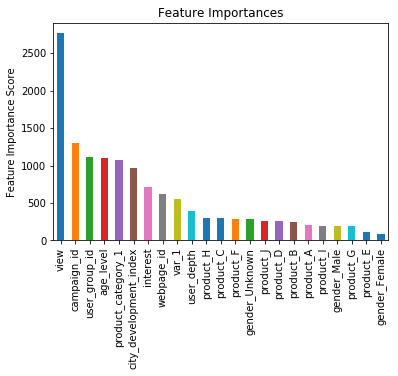

In [229]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=500,
        max_depth=5,
        min_child_weight=4,
        reg_alpha=1,
        gamma=0,
        subsample=0.85,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, trainset, testset, predictors)

In [230]:
prediction=pd.Series(test_pred.tolist()).astype(int)

In [231]:
prediction.to_csv('D:/My Personal Documents/Learnings/Data Science/Data Sets/AmericanExpress/predictionuxgb.csv')

In [232]:
test.shape

(128858, 24)